In [1]:
import numpy as np
import scipy.linalg as LA
from scipy.linalg import eigh
import matplotlib.pyplot as plt
from scipy.sparse.linalg import eigsh
from scipy.sparse import lil_matrix
from scipy.special import binom
from itertools import combinations

plt.style.use('seaborn-v0_8-paper')

### Non optimized Functions

In [2]:
def S_z(j, N):
    """Bitwise implementation of S_i^{z}"""
    jbit = 2**(N-j)
    sigma_z = lil_matrix((2**N, 2**N))

    for i in range(2**N):
        if (jbit & i) != 0:
            sigma_z[i,i] += 0.5
        else: 
            sigma_z[i,i] -= 0.5
    return sigma_z

def flip_flop(i, j, N):
    """Bitwise implementation of S_i^{+} S_j^{-} with 0-based indexing. """
    bit_ij = (1 << (N - 1 - i)) | (1 << (N - 1 - j))  # Bitmask for sites i and j
    Si_Sj = lil_matrix((2**N, 2**N)) 

    for I in range(2**N):  
        I_ij = I & bit_ij  
        hop_ij = bit_ij ^ I_ij  

        if I_ij == (1 << (N - 1 - j)):  # j is up and i is down
            new_state = I ^ bit_ij  
            Si_Sj[new_state, I] += 1  # S_i^+ S_j^- action
            Si_Sj[I, new_state] += 1  # Hermitian conjugate
    
    return Si_Sj

In [3]:
N = 3
a = 2

print(S_z(a,N).toarray())

[[-0.5  0.   0.   0.   0.   0.   0.   0. ]
 [ 0.  -0.5  0.   0.   0.   0.   0.   0. ]
 [ 0.   0.   0.5  0.   0.   0.   0.   0. ]
 [ 0.   0.   0.   0.5  0.   0.   0.   0. ]
 [ 0.   0.   0.   0.  -0.5  0.   0.   0. ]
 [ 0.   0.   0.   0.   0.  -0.5  0.   0. ]
 [ 0.   0.   0.   0.   0.   0.   0.5  0. ]
 [ 0.   0.   0.   0.   0.   0.   0.   0.5]]


In [4]:
print(flip_flop(0,1,N).toarray())

[[0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]]


### Implemented Functions

We have to implement now the lookup table I[J]

In [5]:
def binary_permutations(N,num_ones):
    """
    Generate all unique permutations of the binary representation of a given number N.
    Optimized for large N.
    """
    # Convert N to its binary representation
    num_zeros = N - num_ones

    # Total length of the binary string
    total_length = N

    # Generate positions where '1's will be placed
    unique_permutations = []
    for ones_positions in combinations(range(total_length), num_ones):
        # Initialize binary list with all '0's
        binary_list = ['0'] * total_length
        # Place '1's at the chosen positions
        for pos in ones_positions:
            binary_list[pos] = '1'
        # Convert to string and add to the result list
        unique_permutations.append(''.join(binary_list))

    unique_permutations.reverse()
    return unique_permutations

In [6]:
N = 5  # Input number
result = binary_permutations(N,2)
print(f"Number of unique permutations: {len(result)}")
print(result) 

Number of unique permutations: 10
['00011', '00101', '00110', '01001', '01010', '01100', '10001', '10010', '10100', '11000']


In [7]:
def look_index(I, N):
    """
    Compute the index (J_a + J_b) of a state I in a binary basis split into two halves.
    The spin number is implicit in the number of 1's in the binary representation of N.

    Parameters:
    - I : int, the state in decimal representation
    - N : int, the total number of spins

    Returns:
    - int, the computed index (J_a + J_b)
    """
    # Input validation
    if not (0 <= I < 2**N):
        raise ValueError("State I must be between 0 and 2^N - 1.")
    if N <= 0:
        raise ValueError("N must be a positive integer.")

    # Convert I to binary with leading zeros
    binary_str = bin(I)[2:].zfill(N)

    # Split into left and right halves
    mid = N // 2
    left = binary_str[:mid+1]
    right = binary_str[mid+1:]

    # Count the number of 1's (total spin-z components)
    total_σz = binary_str.count('1')
    left_σz = left.count('1')
    right_σz = right.count('1')

    # Calculate J_a
    left_val = int(left, 2)  # Convert `left` binary string to decimal
    multiplicities = {lsz: binom(mid, total_σz - lsz) for lsz in range(total_σz + 1)}  # Precompute multiplicities
    J_a = 0
    for i in range(left_val + 1):
        local_sz = bin(i).count('1')  
        J_a += multiplicities[local_sz]
    J_a -= multiplicities[left_σz]  # We have to rest this to get the number right, equivalent of counting with an strict inequality

    # Calculate J_b (unchanged)
    right_val = int(right, 2)
    r_dgen = int(binom(mid, right_σz))  # Right degeneracy: how many states with given spin-z
    J_b = 0
    k = 1
    while k <= r_dgen:
        J_b += 1
        if k == right_val:break 
        k += 1

    return int(J_a + J_b)

In [20]:
mmm = 5
for i in [3,5,6,9,10,12]:
    print(f'i={bin(i)[2:].zfill(mmm)}', look_index(i,mmm))

i=00011 1
i=00101 2
i=00110 3
i=01001 4
i=01010 5
i=01100 6


In [9]:
def S_z(state, j, N):
    """
    Compute the diagonal action of S_z at site j on the given state.
    """
    if (state >> (N - 1 - j)) & 1:  # If site j is up (1)
        return 0.5
    else:  # If site j is down (0)
        return -0.5

def flip_flop(state, i, j, N):
    """
    Apply the S_i^+ S_j^- + S_i^- S_j^+ operator on a given state.
    """
    if (((state >> (N - 1 - i)) & 1) == 0) and (((state >> (N - 1 - j)) & 1) == 1):
        # Flip spins at sites i and j (S_i^+ S_j^- action)
        new_state = state ^ ((1 << (N - 1 - i)) | (1 << (N - 1 - j)))
        return new_state
    return None

In [10]:
# Parameters
N = 4                     # Total number of sites
state = 0b0101            # Binary: ↓↑↓↑

print("Initial state in binary:", bin(state))

# 1. Compute S_z at site 1 and site 2
Sz_1 = S_z(state, j=1, N=N)
Sz_2 = S_z(state, j=2, N=N)

print(f"S_z at site 1: {Sz_1}")
print(f"S_z at site 2: {Sz_2}")

# 2. Apply the flip-flop operator S_0^+ S_1^- (acting on sites 0 and 1)
new_state = flip_flop(state, i=0, j=1, N=N)

if new_state is not None:
    print("New state after flip-flop (S_0^+ S_1^-):", bin(new_state))
else:
    print("Flip-flop operator had no effect (invalid action).")

Initial state in binary: 0b101
S_z at site 1: 0.5
S_z at site 2: -0.5
New state after flip-flop (S_0^+ S_1^-): 0b1001


Finally, we can implement the Hamiltonian

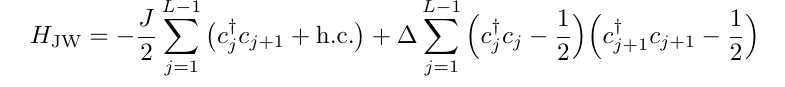

In [11]:
def XXZ_Hamiltonian_OPB(N, total_sz, J=1.0, Delta=1.0):
    """
    Construct the XXZ spin chain Hamiltonian with open boundary conditions (OPB) 
    within a fixed total Sz sector.
    """
    # Generate the basis that conserves total S^z
    basis = binary_permutations(N, total_sz)  # Basis as binary strings
    dim = len(basis) 
    # print(basis)
    # print('Block basis dim:', dim)

    # Initialize the Hamiltonian as a sparse matrix
    H = lil_matrix((dim, dim))

    # Construct the Hamiltonian
    for idx, state in enumerate(basis):
        state = int(state, 2)  # Convert binary string to integer
        
        for j in range(N - 1):  # Open boundary conditions        
            # ZZ term (interaction between sites j and j+1)
            Sz_j = S_z(state, j, N)        # S^z at site j
            Sz_jp1 = S_z(state, j+1, N)    # S^z at site j+1
            H[idx, idx] += Delta * Sz_j * Sz_jp1
            
            # XX + YY term (flip-flop interaction)
            new_state = flip_flop(state, j, j+1, N)
            if new_state is not None and bin(new_state)[2:].zfill(N) in basis:
                # Find the index of the new state in the basis
                new_idx = look_index(new_state, N)-1
                if new_idx is not None:
                    H[idx, new_idx] += -J / 2
                    H[new_idx, idx] += -J / 2  # Hermitian conjugate

    return H

In [26]:
N = 5              # Number of spins
total_sz = N//2        # Total S^z sector
J = 1.0             # Coupling for XX and YY terms
Delta = 1           # Coupling for ZZ term

# Generate the Hamiltonian
H = XXZ_Hamiltonian_OPB(N, total_sz, J, Delta)

# Convert to a dense matrix for display
print("XXZ Hamiltonian in the total Sz = 0 sector:")
print(H.todense())

# Convert to CSR for efficient diagonalization
H_csr = H.tocsr()

# Calculate eigenvalues using Lanczos algorithm (eigs for symmetric matrices)
k = 1  # Number of eigenvalues to compute
eigenvalues = eigsh(H_csr, k=k, which='SA', return_eigenvectors=False)

# Print the eigenvalues
print(f"Eigenvalues of the XXZ Hamiltonian (N={N}, Delta={Delta}):")
print(eigenvalues)

XXZ Hamiltonian in the total Sz = 0 sector:
[[ 0.5 -0.5  0.   0.   0.   0.   0.   0.   0.   0. ]
 [-0.5 -0.5 -0.5 -0.5  0.   0.   0.   0.   0.   0. ]
 [ 0.  -0.5  0.   0.  -0.5  0.   0.   0.   0.   0. ]
 [ 0.  -0.5  0.  -0.5 -0.5  0.  -0.5  0.   0.   0. ]
 [ 0.   0.  -0.5 -0.5 -1.  -0.5  0.  -0.5  0.   0. ]
 [ 0.   0.   0.   0.  -0.5  0.   0.   0.  -0.5  0. ]
 [ 0.   0.   0.  -0.5  0.   0.   0.  -0.5  0.   0. ]
 [ 0.   0.   0.   0.  -0.5  0.  -0.5 -0.5 -0.5  0. ]
 [ 0.   0.   0.   0.   0.  -0.5  0.  -0.5 -0.5 -0.5]
 [ 0.   0.   0.   0.   0.   0.   0.   0.  -0.5  0.5]]
Eigenvalues of the XXZ Hamiltonian (N=5, Delta=1):
[-1.92788625]
